In [22]:
import sys
import dask
import importlib
import numpy as np
import dask.array as da
from distributed import Client

dask.config.set({"distributed.diagnostics.nvml": False})

client = Client()

if 'custom_optimizations' in sys.modules:
    del sys.modules['custom_optimizations']

from custom_optimizations import custom_optimization
dask.config.set({"optimizations": [custom_optimization]})

x = da.ones((10000, 10000), chunks=(1000, 1000))
# y = x + 2
# z = x * 4
# w = da.sin(y) * da.cos(z)
# v = da.sqrt(y) + w
# future = v.mean() - z.sum()
future = x.sum()

try:
    result = future.compute
    print(x.chunks)
    print(f"Result of sum: {result}")
finally:
    client.close()

((1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000), (1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000))
Result of sum: <bound method DaskMethodsMixin.compute of dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>>


In [38]:
import dask.array as da

# Define your custom rechunking function
def custom_rechunk(arr, chunks, *args, **kwargs):
    print(f"Custom rechunking with chunks: {chunks}")
    print(arr.__dir__())
    
    # You can add custom logic here before calling the actual rechunk
    # For example, adding logging, checking conditions, etc.
    
    # Call the original rechunk function
    return arr.rechunk(chunks, *args, **kwargs)

# Example usage
x = da.ones((10000, 10000), chunks=(1000, 1000))
y = x.sum()

# Call the custom rechunk function
x_rechunked = custom_rechunk(y, (500, 500))
print(x_rechunked)

Custom rechunking with chunks: (500, 500)
['shape', 'ndim', '__module__', '__doc__', '__slots__', '__new__', '__reduce__', '__dask_graph__', '__dask_layers__', '__dask_keys__', '__dask_tokenize__', '__dask_optimize__', '__dask_scheduler__', '__dask_postcompute__', '__dask_postpersist__', '_rebuild', '_reset_cache', '_key_array', 'numblocks', 'npartitions', 'compute_chunk_sizes', 'chunksize', 'dtype', '_chunks', 'chunks', '__len__', '__array_ufunc__', '__repr__', '_repr_html_', 'size', 'nbytes', 'itemsize', '_name', 'name', '__iter__', '__array_priority__', '__array__', '__array_function__', '_elemwise', 'store', 'to_svg', 'to_hdf5', 'to_dask_dataframe', 'to_backend', '__bool__', '__nonzero__', '_scalarfunc', '__int__', '__long__', '__float__', '__complex__', '__index__', '__setitem__', '__getitem__', '_vindex', 'vindex', 'blocks', 'partitions', 'dot', 'A', 'T', 'transpose', 'ravel', 'flatten', 'choose', 'reshape', 'topk', 'argtopk', 'astype', '__abs__', '__add__', '__radd__', '__and__'

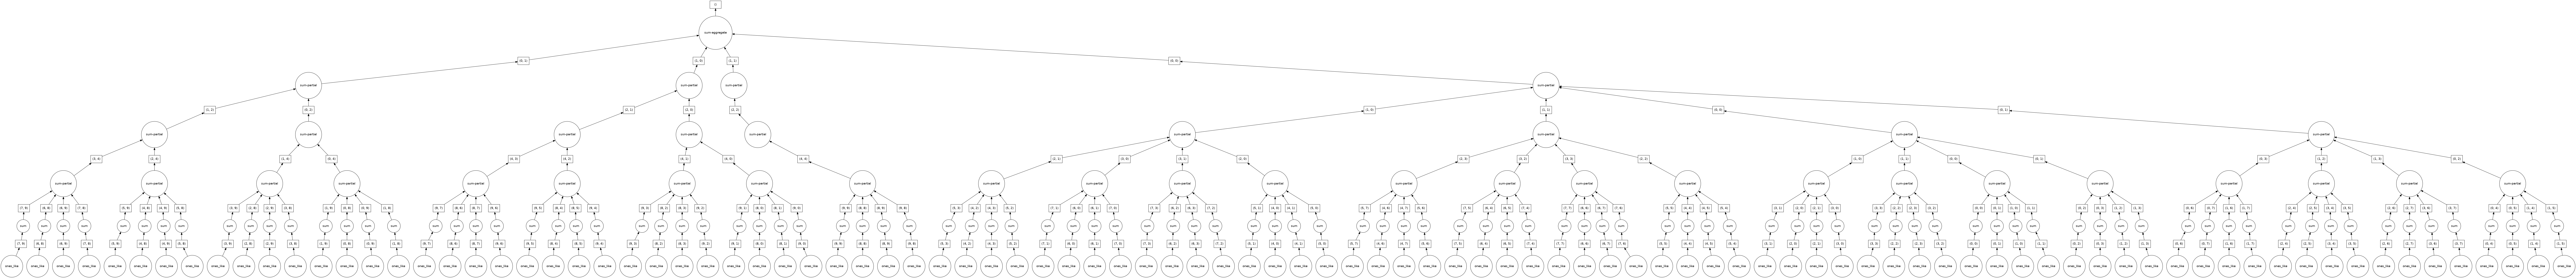

In [21]:
future.visualize()

In [2]:
# import dask.array as da
# from dask.distributed import Client, SchedulerPlugin
# from psutil import Process

# class AutoChunkSizeSchedulerPlugin(SchedulerPlugin):
#     def __init__(self, array, initial_chunks=2, max_memory_fraction=0.8):
#         """
#         Scheduler Plugin to adjust chunk size based on memory usage.

#         Parameters:
#         - array: The Dask array to adjust chunk size for.
#         - initial_chunks: Number of chunks to process before adjusting chunk size.
#         - max_memory_fraction: The fraction of total memory to use before adjusting chunk size.
#         """
#         self.array = array  # Store the reference to the original Dask array
#         self.initial_chunks = initial_chunks
#         self.max_memory_fraction = max_memory_fraction
#         self.memory_usages = []
#         self.is_chunk_adjusted = False
#         self.scheduler = None  # Reference to the scheduler

#     def start(self, scheduler):
#         """Store the reference to the scheduler when the plugin is registered."""
#         self.scheduler = scheduler  # Store the scheduler reference for later use

#     def transition(self, key, start, finish, *args, **kwargs):
#         """
#         Hook that runs when a task transitions between states (like processing -> memory).
#         Used to monitor memory usage after each chunk.
#         """
#         print(finish)
#         if finish == 'memory' and not self.is_chunk_adjusted:
#             rss = Process().memory_info().rss
#             print(rss)
#             return
#             memory_info = psutil.virtual_memory()
#             used_memory = memory_info.used
#             total_memory = memory_info.total

#             # Record memory usage for the first few chunks
#             if len(self.memory_usages) < self.initial_chunks:
#                 self.memory_usages.append(used_memory)
#                 if len(self.memory_usages) == self.initial_chunks:
#                     # Adjust chunk size after collecting memory stats
#                     self.adjust_chunk_size(total_memory)
#                     self.is_chunk_adjusted = True

#     def adjust_chunk_size(self, total_memory):
#         """Adjust chunk size based on observed memory usage and resubmit the computation."""
#         avg_memory_usage = (sum(self.memory_usages) / len(self.memory_usages))  # Average memory per chunk
#         max_memory_usage = total_memory * self.max_memory_fraction

#         # Calculate the chunk memory size we want to use
#         safe_chunk_memory_usage = max_memory_usage  # Fit chunks into available memory
#         chunk_scaling_factor = safe_chunk_memory_usage / avg_memory_usage  # Adjust the chunk size based on memory

#         logger.info(f"Adjusting chunk size based on scaling factor: {chunk_scaling_factor:.2f}.")

#         # Retrieve the current client
#         client = Client.current()

#         # Cancel all active futures safely
#         logger.info("Attempting to cancel all pending or running futures...")
#         futures = client.futures
#         for future_key, future in futures.items():
#             if future.status in ['pending', 'running']:  # Only cancel pending and running tasks
#                 try:
#                     logger.info(f"Cancelling future: {future_key}")
#                     future.cancel()
#                 except Exception as e:
#                     logger.error(f"Error while cancelling future {future_key}: {e}")

#         # Get the shape and chunks of the array
#         original_chunks = self.array.chunks
#         original_shape = self.array.shape

#         # Calculate new chunk sizes based on the memory scaling factor
#         new_chunk_size = []
#         for dim_size, dim_chunks in zip(original_shape, original_chunks):
#             # Calculate the new chunk size for each dimension
#             total_dim_size = sum(dim_chunks)  # Total size for this dimension
#             new_chunk_count = max(1, int(total_dim_size * chunk_scaling_factor))
#             chunk_size_per_dim = dim_size // new_chunk_count
#             last_chunk_size = dim_size - (chunk_size_per_dim * (new_chunk_count - 1))
            
#             # Ensure that the chunk size is reasonable and doesn't cause issues
#             chunk_sizes = [chunk_size_per_dim] * (new_chunk_count - 1) + [last_chunk_size]
#             new_chunk_size.append(tuple(chunk_sizes))

#         new_chunk_size = tuple(new_chunk_size)
#         logger.info(f"Original chunk size: {original_chunks}, New chunk size: {new_chunk_size}")

#         # Rechunk the array
#         logger.info("Rechunking the array...")
#         rechunked_array = self.array.rechunk(new_chunk_size)

#         # Compute the rechunked array
#         logger.info("Recomputing the rechunked array...")
#         rechunked_array.compute()
#         logger.info("Computation complete with new chunk sizes.")

# array = da.random.random((10000, 10000), chunks=(1000, 1000))
# plugin = AutoChunkSizeSchedulerPlugin(array, initial_chunks=3)
# client.register_scheduler_plugin(plugin)

# future = array.sum()
# result = future.compute()
# print(f"Initial result: {result}")